In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from pprint import pprint

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [11]:
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = 'Primary Key'
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [13]:
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = 'Primary Key'
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Climate Analysis

In [14]:
session.query(func.count(Measurement.date)).all()

[(19550)]

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last date is: {lastdate[0]}")

lastdate = dt.datetime.strptime(lastdate[0], '%Y-%m-%d')
querydate = dt.date(lastdate.year -1, lastdate.month, lastdate.day)
print(f"Date from one year ago is: {querydate}")

Last date is: 2017-08-23
Date from one year ago is: 2016-08-23


In [19]:
# Perform a query to retrieve the data and precipitation scores
meas_cols = (Measurement.date, Measurement.prcp)

prcp_data = session.query(*meas_cols).\
    filter(Measurement.date >= querydate).all()
prcp_data[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data,columns = ['date', 'precipitation'])
prcp_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [21]:
# Sort the dataframe by date
prcp_df.set_index('date',inplace = True)
prcp_df = prcp_df.sort_index()
prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


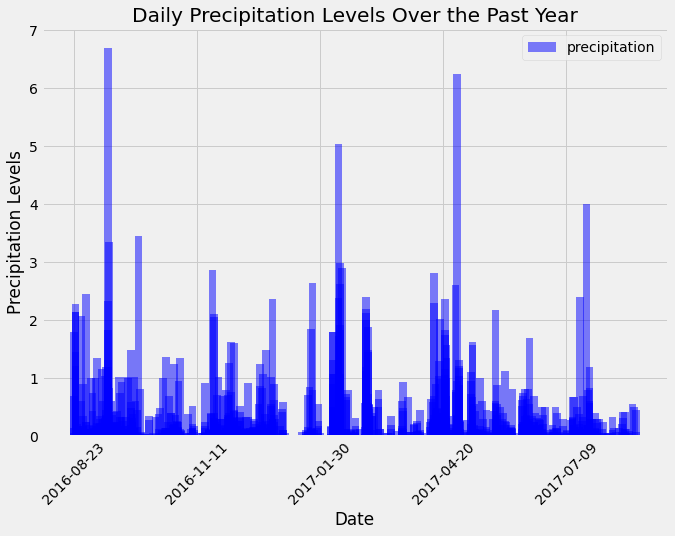

In [23]:
xx = prcp_df.index.tolist()
yy = prcp_df['precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center",label='precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks, rotation = 45)


plt.title("Daily Precipitation Levels Over the Past Year")
plt.xlabel("Date")
plt.ylabel("Precipitation Levels")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [25]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f'Number of Stations = {station_count}')

Number of Stations = 9


In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, Station.name, func.count(Measurement.id)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
print("Most active stations are:")
pprint(most_active)

Most active stations are:
[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

station_data = session.query(*sel).filter(Measurement.station == most_active[0][0]).all()
station_data

print(f"Most active station is {most_active[0][0]} - {most_active[0][1]}")
print(f"Lowest Temperature: {station_data[0][0]}F")
print(f"Highest Temperature: {station_data[0][1]}F")

rounded = round(station_data[0][2], 3)
print(f"Average Temperature: {rounded}F")


Most active station is USC00519281 - WAIHEE 837.5, HI US
Lowest Temperature: 54.0F
Highest Temperature: 85.0F
Average Temperature: 71.664F


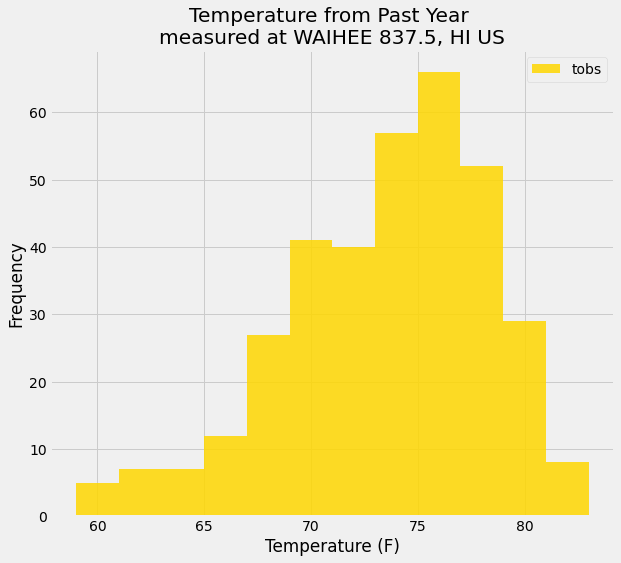

In [28]:
# Query the last 12 months of temperature data for the most active station and plot the results
temp_results = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.date > querydate)
    .filter(Measurement.station == most_active[0][0])
    .order_by(Measurement.date)
    .all()
)

temp_df = pd.DataFrame(temp_results)
temp_df = temp_df.set_index("date").sort_index(ascending=True)

temp_df.plot(kind = 'hist', color = 'gold', bins = 12, alpha=0.85, figsize=(9,8))
plt.title(f"Temperature from Past Year \nmeasured at {most_active[0][1]}")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

 - Hawaii is reputed to enjoy mild weather all year.  Is there a meaningful difference between temperature in June and December
 
 - Identify average temperature in June at all stations across the available years in the dataset. Do the same for the December temperature.
 
 - Use t-test to determine whether the difference in means is statistically significant.



In [29]:
#get raw data from June and December
june_data = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime('%m', Measurement.date) == '06').all()
dec_data = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime('%m', Measurement.date) == '12').all()

#convert to DataFrames and concatenate
june_df = pd.DataFrame(june_data, columns=["Date", 'Temperature'])
dec_df = pd.DataFrame(dec_data, columns=['Date', 'Temperature'])
june_df['Month'] = 'June'
dec_df['Month'] = 'December'
temp_df = pd.concat([june_df, dec_df], ignore_index=True)
temp_df

,Date,Temperature,Month
0,2010-06-01,78.0,June
1,2010-06-02,76.0,June
2,2010-06-03,78.0,June
3,2010-06-04,76.0,June
4,2010-06-05,77.0,June
...,...,...,...
3212,2016-12-27,71.0,December
3213,2016-12-28,71.0,December
3214,2016-12-29,69.0,December
3215,2016-12-30,65.0,December


In [30]:
# calc avg temp for both months
avg_temp = temp_df.groupby("Month").mean()
avg_temp

,Temperature
Month,
December,71.041529
June,74.944118


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

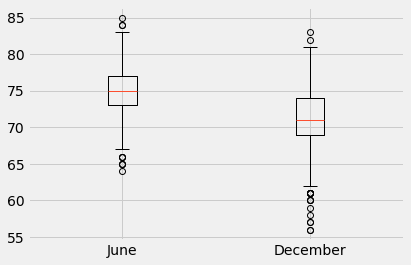

In [31]:
#Using thje unpaired t-test to compare means from separate months that are not dependant on each other

#null hypothesis - differenece between the mean temperatures is equal to 0
#H1 - the difference between the mean temperatures of June and December is not equal to 0

box_data = [june_df["Temperature"], dec_df["Temperature"]]
plt.boxplot(box_data, labels=['June', 'December'])
stats.ttest_ind(june_df['Temperature'], dec_df['Temperature'])

The p-value is less 0.05, so we can reject the null hypothesis.  We can conclude that the difference in mean temperature in Hawaii in the months of June and December is statistically significant.

## Temperature Analysis II

In [60]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example - given in starter
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [101]:
# function ran with my chosen dates:
start_date = '2017-05-01'
end_date = '2017-05-15'
trip_dates = '2017-05-01 to 2017-05-15'
trip_temps = calc_temps('2017-05-01', '2017-05-15')
temp_min, temp_avg, temp_max = trip_temps[0]
print(f'Weather Results for {trip_dates}:')
pprint(f'Minimum Temperature: {temp_min}F')
round_temp = round(temp_avg, 3)
pprint(f'Average Temperature: {round_temp}F')
pprint(f'Maximum Temperature: {temp_max}F')

Weather Results for 2017-05-01 to 2017-05-15:
'Minimum Temperature: 65.0F'
'Average Temperature: 75.238F'
'Maximum Temperature: 80.0F'


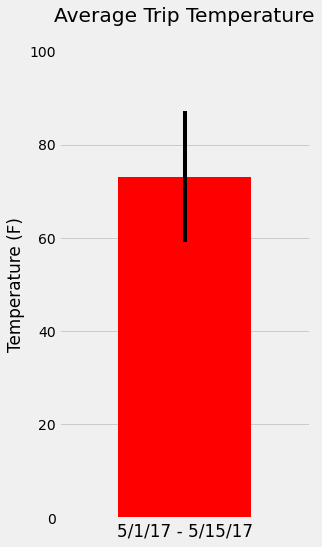

In [100]:
xpos=[0]
ypos = temp_avg
error = temp_max - temp_min

plt.figure(figsize=(4,8))
plt.bar(xpos, ypos, color='red', yerr=error)
plt.xlim(-0.75, 0.75)
plt.title("Average Trip Temperature", y=1.05)
plt.xlabel('5/1/17 - 5/15/17')
plt.ylabel('Temperature (F)')
plt.ylim(0, 100)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

## Daily Rainfall Average

In [99]:
# Calculate the total amount of rainfall per weather station for your trip dates 
    #using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, 
    #latitude, longitude, and elevation
start_date = '2017-05-01'
end_date = '2017-05-15'

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, 
          func.sum(Measurement.prcp)]
queryres = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    order_by(func.sum(Measurement.prcp).desc()).all()

stations = pd.DataFrame(queryres, columns=['Station', 'Name', 'Latitude', 'Longitude', 
                                           'Elevation', 'PrcpSum'])
stations = stations.style.set_caption("Station Data During Trip Dates: 2017-05-01 to 2017-05-15")
stations

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.333100,-157.802500,152.400000,4.510000
1,USC00519281,"WAIHEE 837.5, HI US",21.451670,-157.848890,32.900000,3.200000
2,USC00513117,"KANEOHE 838.1, HI US",21.423400,-157.801500,14.600000,2.290000
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.521300,-157.837400,7.000000,1.940000
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.335560,-157.711390,19.500000,0.870000
5,USC00519397,"WAIKIKI 717.2, HI US",21.271600,-157.816800,3.000000,0.320000


In [90]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [111]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start(trip_sd) and end date(trip_ed) of the trip
trip_sd = '2017-05-01'
trip_ed = '2017-05-15'

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

##sd = start date
## ed = end date
sd = dt.datetime.strptime(trip_sd, '%Y-%m-%d')
ed = dt.datetime.strptime(trip_ed, '%Y-%m-%d')

trip_dates = []
normals = []
while (sd <= ed):
    trip_dates.append(dt.datetime.strftime(sd, '%Y-%m-%d'))
    datestr = dt.datetime.strftime(sd, '%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    sd = sd + dt.timedelta(days = 1)
    
normals

[[65.0, 72.75925925925925, 79.0],
 [65.0, 73.05084745762711, 79.0],
 [67.0, 73.41071428571429, 84.0],
 [65.0, 73.59649122807018, 78.0],
 [67.0, 73.39655172413794, 79.0],
 [66.0, 73.14035087719299, 80.0],
 [64.0, 71.78846153846153, 79.0],
 [65.0, 72.18867924528301, 80.0],
 [67.0, 72.9322033898305, 79.0],
 [64.0, 73.3157894736842, 78.0],
 [65.0, 73.61111111111111, 79.0],
 [65.0, 73.13793103448276, 79.0],
 [67.0, 73.14285714285714, 79.0],
 [63.0, 73.89285714285714, 80.0],
 [63.0, 73.69090909090909, 79.0]]

In [112]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_history = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_history['Date'] = trip_dates
trip_history = trip_history.set_index("Date")
trip_history

,tmin,tavg,tmax
Date,,,
2017-05-01,65.0,72.759259,79.0
2017-05-02,65.0,73.050847,79.0
2017-05-03,67.0,73.410714,84.0
2017-05-04,65.0,73.596491,78.0
2017-05-05,67.0,73.396552,79.0
2017-05-06,66.0,73.140351,80.0
2017-05-07,64.0,71.788462,79.0
2017-05-08,65.0,72.188679,80.0
2017-05-09,67.0,72.932203,79.0


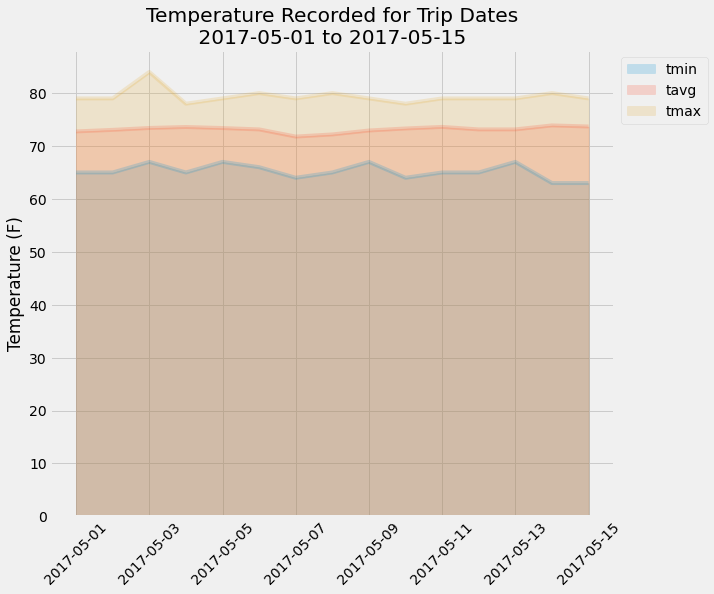

In [118]:
# Plot the daily normals as an area plot with `stacked=False`
trip_history.plot(kind='area', stacked=False, rot=45, alpha=.2, figsize=(9,8))
plt.xticks(rotation=45)
plt.title(f"Temperature Recorded for Trip Dates\n {trip_sd} to {trip_ed} ")
plt.xlabel("")
plt.ylabel("Temperature (F)")
plt.legend(bbox_to_anchor=(1,1))